In [13]:
import gym
import numpy as np
import tensorflow as tf
from tensorflow.contrib import slim

import os
import random
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
style.use('ggplot')
%matplotlib inline

In [2]:
env = gym.make('MountainCar-v0')
n_features = env.observation_space.shape[0]
n_actions = env.action_space.n

[2016-12-16 18:24:30,359] Making new env: MountainCar-v0


In [3]:
class Approximator():
    ''' Creates an ANN to aporoximate Q values '''
    
    def __init__(self, n_features, n_actions, hidden_size, learning_rate=1e-2, clip_grads=False, summary_name=None):
        self.build(n_features, n_actions, hidden_size, learning_rate, clip_grads)
        self.summary_writer = None
        if summary_name:
            # Make summary dir        
            if not os.path.exists('summary'):
                os.mkdir('summary')
            self.summary_writer = tf.train.SummaryWriter('summary/q_learning/{}'.format(summary_name))                     
        
    def build(self, n_features, n_actions, hidden_size, learning_rate, clip_grads):
        # Placeholders
        self.X = tf.placeholder(name='input', shape=[None, n_features], dtype=tf.float32)
        self.Y = tf.placeholder(name='target', shape=[None], dtype=tf.float32)
        self.action = tf.placeholder(name='chosen_action', shape=[None], dtype=tf.int32)
        # Stores the time step
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        
        # Network body
        self.hidden = slim.fully_connected(inputs=self.X, num_outputs=hidden_size, activation_fn=tf.nn.sigmoid)
        self.Q = slim.fully_connected(inputs=self.hidden, num_outputs=n_actions, activation_fn=None)
        
        # Loss
        # Get the action value only for the chosen action
        batch_size = tf.shape(self.X)[0]
        action_ids = tf.range(batch_size) * tf.shape(self.Q)[1] + self.action
        self.actions_value = tf.gather(tf.reshape(self.Q, [-1]), action_ids)
        # Use the mean squared error
        self.loss = tf.reduce_mean(tf.squared_difference(self.Y, self.actions_value))
        # Compute and apply gradients
        self.opt = tf.train.AdamOptimizer(learning_rate)
        if clip_grads == True:                    
            self.grads_and_vars = self.opt.compute_gradients(self.loss)
            self.clipped_grads = [(tf.clip_by_value(grad, -1, 1), var) for grad, var in self.grads_and_vars]
            self.train_op = self.opt.apply_gradients(self.grads_and_vars, self.global_step)
        else:
            self.train_op = self.opt.minimize(self.loss, self.global_step)
        
        # Tensorboard summaries
        self.summaries = tf.merge_summary([
                tf.histogram_summary('q_values', self.Q),
                tf.scalar_summary('max_q_values', tf.reduce_max(self.Q)),
                tf.scalar_summary('loss', self.loss),               
            ])
        
    def predict(self, sess, state):
        ''' Calculate Q value '''
        return sess.run(self.Q, feed_dict={self.X:state})
    
    def update(self, sess, state, action, target):
        ''' Update weights and write summary '''
        feed_dict = {self.X:state, self.action:action, self.Y:target}
        summary, _ = sess.run([self.summaries, self.train_op], feed_dict=feed_dict)  
        step = sess.run(self.global_step)
        if self.summary_writer:
            self.summary_writer.add_summary(summary, step)      

In [4]:
class Replay_Memory():
    ''' Stores states and transitions used to train the network '''
    def __init__(self, limit=100000):
        self.memory = []
        self.limit = limit
        
    def add(self, state, action, reward, next_state, done):
        ''' Adds a new experience to memory '''
        if len(self.memory) == self.limit:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))
        
    def sample(self, batch_size):
        ''' Returns random experiences '''
        return random.sample(self.memory, batch_size)      

In [5]:
def epolicy(Q, epsilon):
    ''' Make an epsilon greedy choice '''   
    A = (np.ones(n_actions) * epsilon) / n_actions
    best_action = np.argmax(np.squeeze(Q))
    A[best_action] += (1 - epsilon)    
    return A

In [67]:
def convolve(x, window_size):
    ''' Take the mean of array over window '''
    weigths = np.repeat(1.0, window_size) / window_size
    return np.convolve(np.mean(x, axis=0), weigths, 'same')

In [6]:
def visualize(sess, Q):
    ''' Visualize Q function '''
    # Range of states
    pos = np.linspace(-1.2, 0.6, 100)
    vel = np.linspace(-0.07, 0.07, 100)        
    # Make a grid from states
    X, Y = np.meshgrid(pos, vel) # [100, 100], [100, 100]
    # Reshape to feed to the network
    X_flat, Y_flat = X.flatten(), Y.flatten()
    states = np.c_[X_flat, Y_flat] # [10000, 2]
    # Predict Q values
    Z = Q.predict(sess, states)
    # Get max Q values
    Z_max = np.max(Z, axis=1)
    Z_max = Z_max.reshape(X.shape)
    # Plot
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(X, Y, -Z_max, cmap='jet')
    # Labels
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    # Camera angle
    ax.view_init(40, 55)
    plt.show()

In [7]:
def test_updates(n_updates=100, batch_size=100, learning_rate=1e-2):
    ''' Test if weights updates are affecting mostly the chosen action '''
    tf.reset_default_graph()
    test = Approximator(n_features, n_actions, 10, learning_rate)
    states = [env.observation_space.sample() for _ in range(batch_size)]
    targets = 10 * np.ones(batch_size)
    for action in range(n_actions):
        Q_diff = []
        actions = action * np.ones(batch_size)
        # Reinitialize model for each action because ADAM optimizer builds momentum
        with tf.Session() as sess:
            tf.initialize_all_variables().run()
            for _ in range(n_updates):
                Q_old = np.mean(test.predict(sess, states), axis=0)
                test.update(sess, states, actions, targets)
                Q_new = np.mean(test.predict(sess, states), axis=0)
                Q_diff.append(Q_new - Q_old)
            print('Action {}: {}'.format(action, np.sum(Q_diff, axis=0)))

In [8]:
test_updates()

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Action 0: [ 6.84183455  0.01426609 -0.05848235]
Action 1: [ 0.33944905  6.62673426 -0.34136963]
Action 2: [ 0.06616461  0.02795918  7.02901173]


In [75]:
def train(n_episodes, learning_rate, discount_factor=0.99, epsilon_max=1, epsilon_min=0.01,
          hidden_size=16, clip_grads=False, batch_size=32, min_replays=10000, plot_Q=True, summary=None):
    
    # Create the network to approximate Q function
    tf.reset_default_graph()
    Q_aprox = Approximator(n_features, n_actions, hidden_size, learning_rate, clip_grads=clip_grads, summary_name=summary)
    ep_length = []
    
    # Create experience replay
    replays = Replay_Memory()
    state = env.reset()
    # Fill replay memory with random actions
    action_probs = np.ones(n_actions) / n_actions
    for _ in range(min_replays):
        action = np.random.choice(np.arange(n_actions), p=action_probs)
        next_state, reward, done, _ = env.step(action)
        # Record experience
        replays.add(state, action, reward, next_state, done)
        # Update state
        state = next_state
        if done:
            state = env.reset()    

    with tf.Session() as sess:
        tf.initialize_all_variables().run()

        for i_episode in range(n_episodes + 1):
            state = env.reset()
            # Exponentially decay epsilon
            epsilon = epsilon_min + (epsilon_max - epsilon_min) * np.exp(-1e-2 * i_episode)            

            # Repeat until episode is finished
            for t in itertools.count():
                # Choose an action
                Q = Q_aprox.predict(sess, [state])
                action_probs = epolicy(Q, epsilon)   
                action = np.random.choice(np.arange(n_actions), p=action_probs)
                # Do the action
                next_state, reward, done, _ = env.step(action)
                # Record experience
                replays.add(state, action, reward, next_state, done)

                # Get replays to train on
                b_state, b_action, b_reward, b_next_state, b_done = map(np.array, zip(*replays.sample(batch_size)))
                # Generate td_targets (target is only the reward if done)
                Q_next = Q_aprox.predict(sess, b_next_state)
                Q_next_max = np.max(Q_next, axis=1)
                b_td_targets = b_reward + np.bitwise_xor(b_done, 1) * (discount_factor * Q_next_max)
                # Update weights
                Q_aprox.update(sess, b_state, b_action, b_td_targets)

                # Update state        
                if done:
                    break
                state = next_state
            
            # Add episode length to tensorboard
            if summary is not None:                
                episode_summary = tf.Summary()
                episode_summary.value.add(simple_value=t, tag='Episode length')
                Q_aprox.summary_writer.add_summary(episode_summary, i_episode)

            # Store statistics         
            ep_length.append(t)
            # Print episode information
            print('\rEpisode: {}/{}'.format(i_episode, n_episodes), end=' | ', flush=True)
            print('Episode length: {}'.format(np.mean(ep_length[-1])), end='', flush=True)            
            if i_episode % (n_episodes//5) == 0:
                start = i_episode - n_episodes//5 - 1
                end = i_episode + 1
                print('\rEpisode: {}/{}'.format(i_episode, n_episodes), end=' | ', flush=True)
                print('Average length: {}'.format(np.mean(ep_length[start:end])), end='', flush=True)
                if plot_Q:
                    visualize(sess, Q_aprox)
            
    return ep_length

In [10]:
eps_length = [train(n_episodes=1000, learning_rate=3e-4, epsilon_max=0.3, clip_grads=False,
                   plot_Q=False, summary='run{}_unclipped'.format(i)) for i in range(10)]

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode: 999/1000 | Episode length: 159.0

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode: 0/1000 | Average length: 4709.0

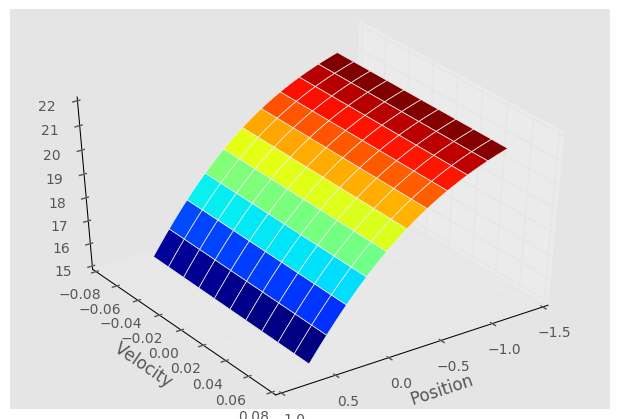

Episode: 200/1000 | Average length: 189.0

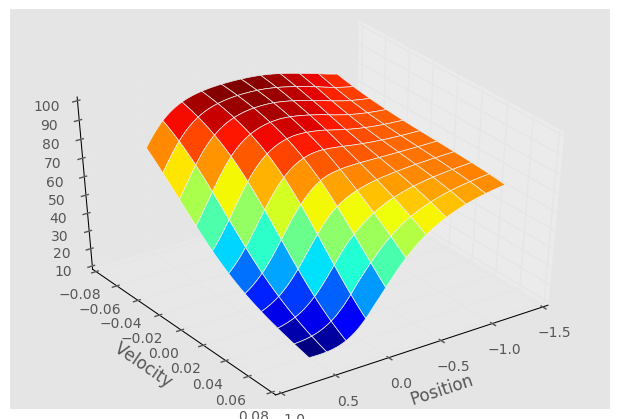

Episode: 400/1000 | Average length: 207.30693069306932

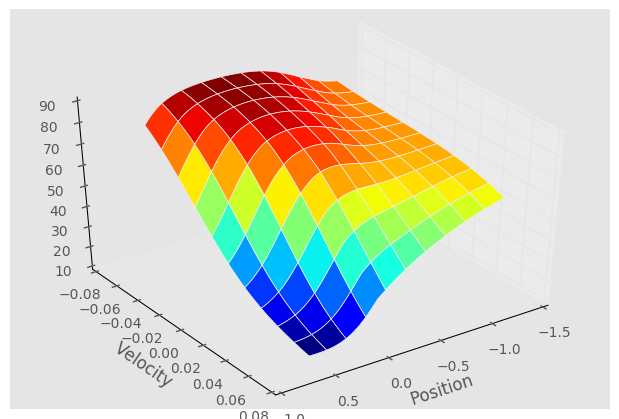

Episode: 600/1000 | Average length: 169.0891089108911

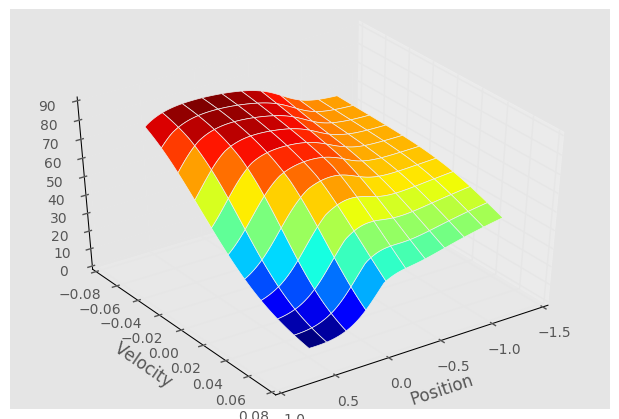

Episode: 800/1000 | Average length: 146.55445544554456

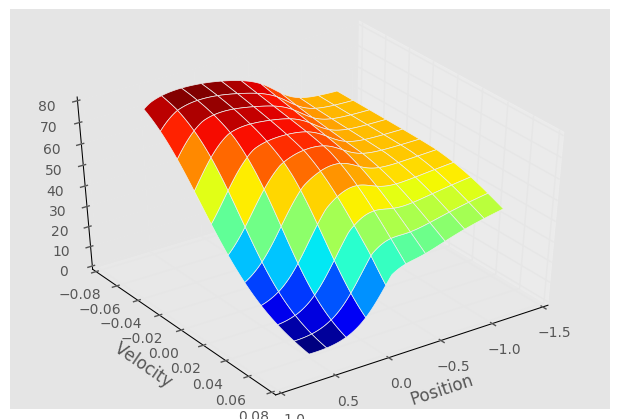

Episode: 1000/1000 | Average length: 158.22277227722773

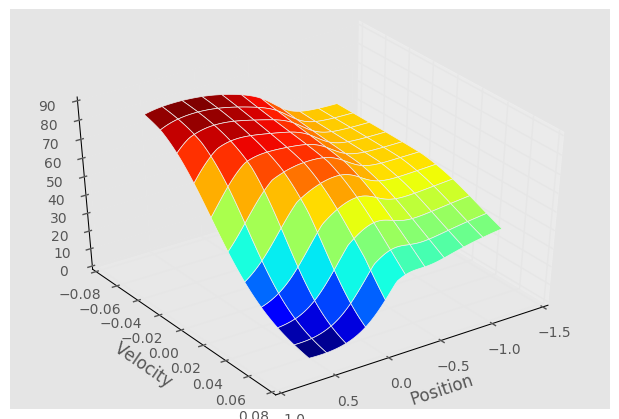

In [77]:
ep_length = train(n_episodes=1000, learning_rate=3e-4, epsilon_max=0.3, clip_grads=False)

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode: 0/1000 | Average length: 1616.0

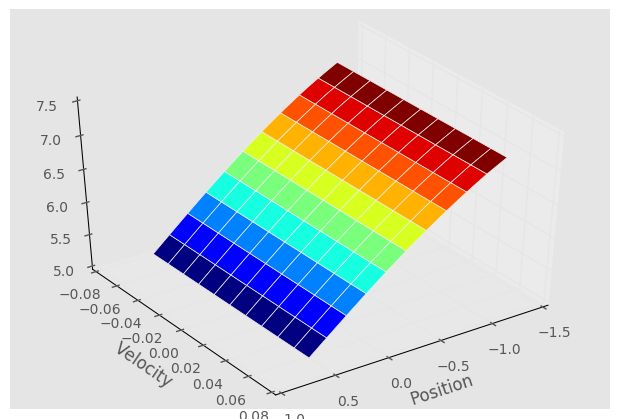

Episode: 200/1000 | Average length: 252.0

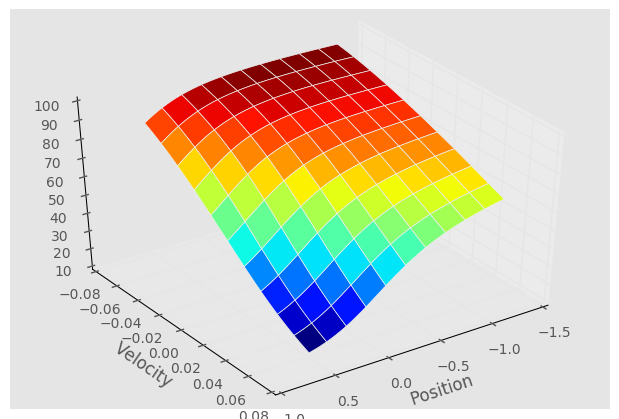

Episode: 400/1000 | Average length: 815.3267326732673

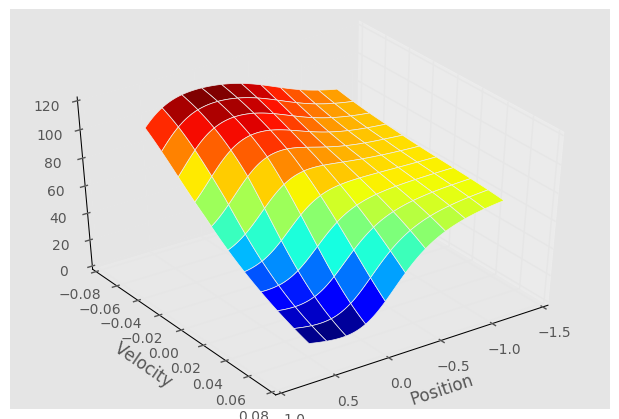

Episode: 600/1000 | Average length: 310.7178217821782

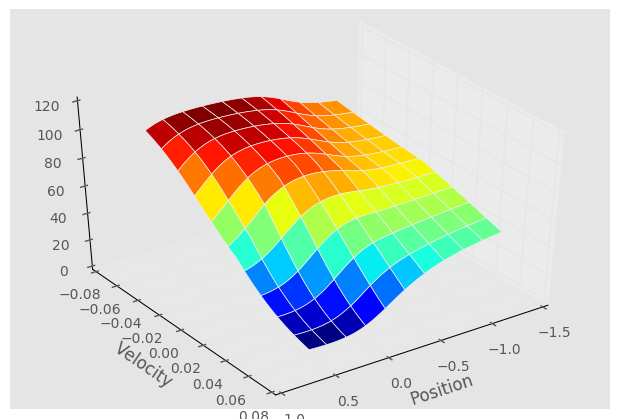

Episode: 800/1000 | Average length: 385.5990099009901

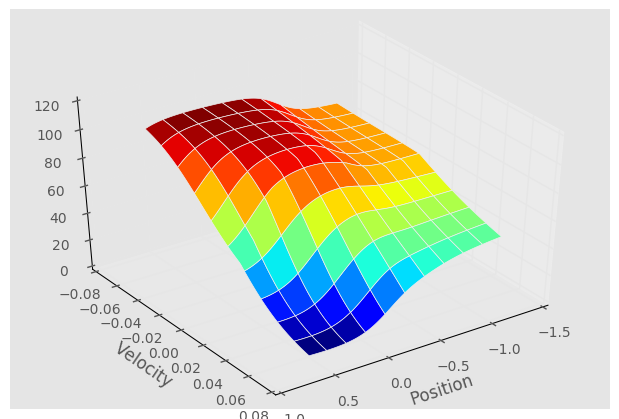

Episode: 1000/1000 | Average length: 245.56435643564356

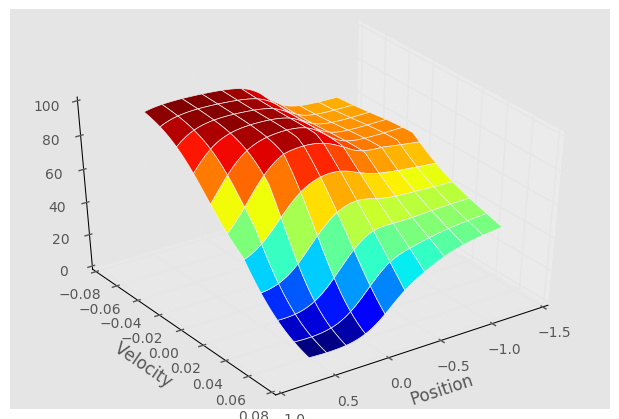

In [79]:
ep_length = train(n_episodes=1000, learning_rate=3e-4, epsilon_max=0.3, clip_grads=True)

In [11]:
eps_length_clipped = [train(n_episodes=1000, learning_rate=3e-4, epsilon_max=0.3, clip_grads=True, 
                            plot_Q=False, summary='run{}_clipped'.format(i)) for i in range(10)]

/home/quazar/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Episode: 999/1000 | Episode length: 267.0

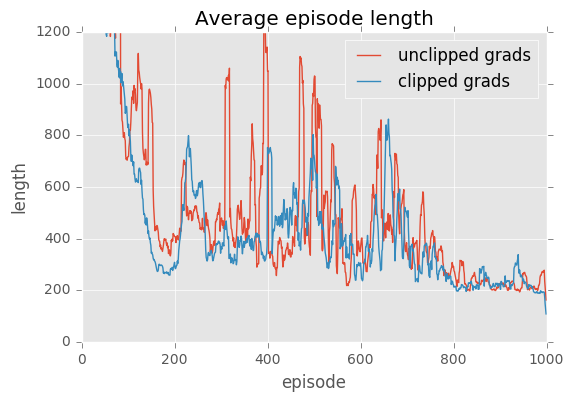

In [72]:
# Plot mean episodes length smoothed over a window size of 10
plt.plot(convolve(eps_length, 10), label='unclipped grads')
plt.plot(convolve(eps_length_clipped, 10), label='clipped grads')
plt.title('Average episode length')
plt.xlabel('episode')
plt.ylabel('length')
plt.ylim(0, 1200)
plt.legend()